### Importing the necessary Libraries

In [797]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.feature_selection import SequentialFeatureSelector



import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Importing the data

In [798]:
data = pd.read_csv('C:/Users/ritaf/Documents/GitHub/CP/Capstone/No_show_prediction/medical-appointments-no-show-en.csv')

#### About our data

Our data was regards information about aspects that influence patients to attend or not their booked appointments. These are the features it contains:

- "Specialty": specialty that patient received the treatment;
- "Appointment Time": appointment time scheduled;
- "Gender": male or female gender of the patient;
- "Appointment Date": appointment date scheduled;
- "No-show": given whether the patient attended the scheduled appointment or not;
- "No-show Reason": description of the reason why the patient did not attend the scheduled appointment;
- "Disability”: the patient’s motor or intellectual disability;
- "Date of Birth": the patient’s date of birth;
- "Date of Entry into the Service": date of the patient’s first appointment at the CER;
- "City": city where the patient resides;
- "ICD": identifier of the patient’s disease;
- "Appointment Month";
- "Appointment Year";
- "Appointment Shift";
- "Age": patient's age;
- "Under 12 years old": patient's age under 12 years old;
- "Over 60 years old": patient's age over 60 years old;
- "Patient needs companion": patient's needs companion to go to the appointment;
- "Average Temperatura Day": Average temperatura in the day of the appointment;
- "Average Rain Day": Average rain in the day of the appointment;
- "Max Temperature Day": Maximum temperature in the day of the appointment;
- "Max Rain Day": Maximum rainfall in the day of the appointment;
- "Storm Day Before": Heavy rain in the day before the appointment;
- "Rain Intensity": no rain, weak, moderate or heavy rain in the day of the appointment;
- "Heat Intensity": cold, heavy cold, warm, heavy warm or mild in the day of the appointment.

This dataset can be accessed though the following link: https://data.mendeley.com/datasets/wm6w2fvkfj/1


## Data preprocessing

Taking an initial look at our dataframe

In [799]:
data.head()
# We have 49593 rows

,specialty,appointment_time,gender,appointment_date,no_show,no_show_reason,disability,date_of_birth,entry_service_date,city,...,over_60_years_old,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,max_rain_day,rainy_day_before,storm_day_before,rain_intensity,heat_intensity
0,physiotherapy,13:20,M,09/09/2021,yes,surto,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
1,psychotherapy,13:20,M,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
2,speech therapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
3,physiotherapy,13:20,F,09/09/2021,no,NaN,NaN,NaN,NaN,NaN,...,0,0,20.75,0.01,23.7,0.2,1,1,no_rain,mild
4,physiotherapy,14:00,M,09/09/2021,no,NaN,motor,10/10/1954,5/2/2020,B. CAMBORIU,...,1,1,20.75,0.01,23.7,0.2,1,1,no_rain,mild


In [800]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49593 entries, 0 to 49592
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   specialty                42139 non-null  object 
 1   appointment_time         49593 non-null  object 
 2   gender                   49593 non-null  object 
 3   appointment_date         49593 non-null  object 
 4   no_show                  49593 non-null  object 
 5   no_show_reason           1737 non-null   object 
 6   disability               44456 non-null  object 
 7   date_of_birth            39272 non-null  object 
 8   entry_service_date       44438 non-null  object 
 9   city                     44412 non-null  object 
 10  icd                      10717 non-null  object 
 11  appointment_month        49593 non-null  object 
 12  appointment_year         49593 non-null  int64  
 13  appointment_shift        49593 non-null  object 
 14  age                   

From the previous output we can see that:
- Some columns can be delete, like the date_of_birth as we already have age, and appointment_shift as we already have the appointment time
- There are some columns (__no_show_reason__  and __idc__) with a high number of invalid values which we will proceed to drop.
- Some columns must be converted to other data types 

#### Dropping troublesome columns

In [801]:
data.drop(['no_show_reason', 'icd', 'date_of_birth', 'appointment_shift'], axis = 1, inplace = True)
# ICD é o código da doença

#### Missing values

Dropping the remaining null values from the remaining columns

In [802]:
data.dropna(inplace = True)
# ficamos com 34607 rows (dropamos 14986)

In [803]:
data.isna().any()

specialty                  False
appointment_time           False
gender                     False
appointment_date           False
no_show                    False
disability                 False
entry_service_date         False
city                       False
appointment_month          False
appointment_year           False
age                        False
under_12_years_old         False
over_60_years_old          False
patient_needs_companion    False
average_temp_day           False
average_rain_day           False
max_temp_day               False
max_rain_day               False
rainy_day_before           False
storm_day_before           False
rain_intensity             False
heat_intensity             False
dtype: bool

There are no more missing values

In [804]:
data = data.reset_index(drop=True)

#### Features encoding 

Encoding some categorical features

In [805]:
# # Specify the columns to be one-hot encoded
# columns_to_encode = ['specialty', 'gender', 'disability']

# # Create a ColumnTransformer with OneHotEncoder for specified columns
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(), columns_to_encode)
#     ],
#     remainder='passthrough'  # Passthrough other columns not specified for encoding
# )

# # Fit and transform the data
# df_encoded = preprocessor.fit_transform(data)

# # Convert the result back to a DataFrame (optional)
# df_encoded = pd.DataFrame(df_encoded, columns=list(preprocessor.get_feature_names_out()))

# # Concatenate the original DataFrame and the encoded DataFrame
# data = pd.concat([data.reset_index(drop=True), df_encoded], axis=1)

In [806]:
# Specify the columns to be one-hot encoded
columns_to_encode = ['specialty', 'gender', 'disability']

# Create a OneHotEncoder
encoder = OneHotEncoder(sparse=False, dtype=int)

# Fit and transform the specified columns
df_encoded = encoder.fit_transform(data[columns_to_encode])

# Convert the result back to a DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(columns_to_encode))

# Reset the index of the original DataFrame
data = data.reset_index(drop=True)

# Concatenate the original DataFrame and the encoded DataFrame
data = pd.concat([data, df_encoded], axis=1)

# Drop the original columns that were one-hot encoded
data = data.drop(columns=columns_to_encode, axis=1)



In [807]:
distances = {'B. CAMBORIU': 12.3,
             'ITAJAÍ': 2.4,
             'CAMBORIU': 14.2,
             'NAVEGANTES': 6.3,
             'ILHOTA': 23,
             'BOMBINHAS': 49.1,
             'ITAPEMA': 27.1,
             'PORTO BELO': 39.3,
             'PENHA': 28,
             'LUIZ ALVES': 44,
             'BALN. PIÇARRAS': 26.3
          }

data['distances (km)'] = data['city'].map(distances)
data.drop(['city'], axis = 1, inplace = True)

In [808]:
temperature_mapping = {'heavy_cold': -2, 'cold': -1, 'mild': 0, 'warm': 1, 'heavy_warm': 2}
data['heat_intensity'] = data['heat_intensity'].map(temperature_mapping)

In [809]:
rainfall_mapping = {'no_rain': 0, 'weak': 1, 'moderate': 2, 'heavy': 3}
data['rain_intensity'] = data['rain_intensity'].map(rainfall_mapping)

In [810]:
data['no_show'] = data['no_show'].map({'yes': 1, 'no': 0})

#### Date features treatment

Transforming the appointment time into floats

In [811]:
data['appointment_time'] = data['appointment_time'].apply(lambda x: round(int(x.split(':')[0]) + int(x.split(':')[1]) / 60, 1))

Transforming the date of service entry into the patient's antequity

In [812]:
# entry service day into date format
data['entry_service_date'] = pd.to_datetime(data['entry_service_date'], format="%d/%m/%Y", errors='coerce')

# there are some incorrectly represented dates, so we drop them
data = data.dropna(subset=['entry_service_date'])

# creating customer antequity feature
data['patient_antequity'] = pd.to_datetime('now') - pd.to_datetime(data['entry_service_date'])
data['patient_antequity'] = data['patient_antequity'].dt.days

# drop the original feature
data.drop('entry_service_date', axis = 1, inplace = True)

data.reset_index(drop=True, inplace=True)

Creating the day of appointment column, since we already have the month and year columns

In [813]:
# creating the day of appointment column
data['appointment_day'] = pd.to_datetime(data['appointment_date'], format='%d/%m/%Y').dt.day

# we can now drop the appointment_date column
data.drop('appointment_date', axis=1, inplace = True)

Turning the appointment month into a numeric variable

In [814]:
month_mapping = {'jan': 1, 'feb': 2, 'mar': 3,
                 'april': 4, 'may': 5, 'june': 6, 'july': 7, 'aug': 8,
                 'sept': 9, 'oct': 10, 'nov': 11, 'dec': 12}

data['appointment_month'] = data['appointment_month'].map(month_mapping)

#### Data types correction

In [815]:
data['appointment_year'] = data['appointment_year'].astype('int64')
data['age'] = data['age'].astype('int64')

In [816]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34239 entries, 0 to 34238
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   appointment_time                34239 non-null  float64
 1   no_show                         34239 non-null  int64  
 2   appointment_month               34239 non-null  int64  
 3   appointment_year                34239 non-null  int64  
 4   age                             34239 non-null  int64  
 5   under_12_years_old              34239 non-null  int64  
 6   over_60_years_old               34239 non-null  int64  
 7   patient_needs_companion         34239 non-null  int64  
 8   average_temp_day                34239 non-null  float64
 9   average_rain_day                34239 non-null  float64
 10  max_temp_day                    34239 non-null  float64
 11  max_rain_day                    34239 non-null  float64
 12  rainy_day_before                

#### Data distributions

In [817]:
data.describe().T.head(30)

,count,mean,std,min,25%,50%,75%,max
appointment_time,34239.0,12.658509,3.275160,7.00,9.20,13.30,15.50,18.30
no_show,34239.0,0.085429,0.279523,0.00,0.00,0.00,0.00,1.00
appointment_month,34239.0,6.676801,2.884215,1.00,4.00,7.00,9.00,12.00
appointment_year,34239.0,2017.700050,1.520999,2016.00,2017.00,2017.00,2019.00,2021.00
age,34239.0,18.854610,19.350849,2.00,8.00,11.00,16.00,110.00
under_12_years_old,34239.0,0.578872,0.493747,0.00,0.00,1.00,1.00,1.00
over_60_years_old,34239.0,0.092497,0.289730,0.00,0.00,0.00,0.00,1.00
patient_needs_companion,34239.0,0.671369,0.469722,0.00,0.00,1.00,1.00,1.00
average_temp_day,34239.0,19.568426,3.466628,8.94,17.29,19.92,22.02,27.10
average_rain_day,34239.0,0.181986,0.438737,0.00,0.00,0.01,0.14,4.77


There are two constant features: `rain_day_before` and `storm_day_before`, so we are dropping them

In [818]:
data.drop(['rainy_day_before', 'storm_day_before'], axis = 1, inplace = True)

## Exploratory Data Analysis

Checking the distribution of our target variable

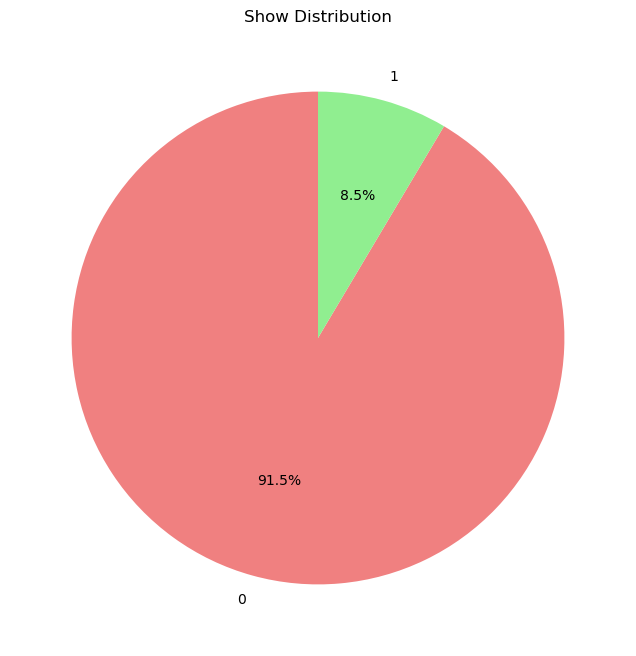

In [819]:
no_show_counts = data['no_show'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(no_show_counts, labels=no_show_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightgreen'])
plt.title('Show Distribution')
plt.show()


We have un unbalanced dataset, with a significante prevalence of patients who did attend their appointments

In [820]:
for column in data.columns:
    print(column, data[column].unique())

appointment_time [14.  14.7 15.3 16.3 17.  17.7 13.3  7.3  8.   8.7 10.3 11.  11.7  9.3
 13.5 16.7 16.  13.  15.   9.7  7.  16.6 13.8 15.5 18.2 17.4 14.8 15.7
 17.3  8.3  9.2 10.5 11.3  7.5 18.   7.8  9.5  8.8 10.8 12.3 14.3 17.2
 16.5 11.2 12.  13.2 15.8 10.   9.8 10.6 13.7 13.1 15.2 12.2 11.5 14.5
 16.2 10.2 10.7  8.2 18.3 17.6  9.1  8.5]
no_show [0 1]
appointment_month [ 9  8  7  6  5  4  3  2 12 11 10  1]
appointment_year [2021 2019 2018 2017 2016 2020]
age [ 68   5  11  28   9  25   7  51  15  52  79  56   3   8   6  42  14  10
  63  23  48   4  39  62  13  69  60  78  12  49  50  73  55  27  17  61
  19  30  58  80  33  70  16  29  31  65  87  64  21  59  38  22  46  67
  54  44  77  26  81  74  32  53  83  35  72  91 110  24  37 106  57  36
  34   2  18  75  82  66  41  86 108  76  47  43  20  71  45]
under_12_years_old [0 1]
over_60_years_old [1 0]
patient_needs_companion [1 0]
average_temp_day [20.75 19.39 18.25 19.15 16.28 18.41 16.63 12.25 20.4  16.4  20.5  20.14
 20.95 23.1

## Modelling

Fazer scaling / normalization

Ver quais são as variaveis mais importantes... aka feature selection

Fazer train test split

Construir modelos... 

In [821]:
X_train.columns

Index(['appointment_time', 'appointment_month', 'appointment_year', 'age',
       'under_12_years_old', 'over_60_years_old', 'patient_needs_companion',
       'average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day',
       'rain_intensity', 'heat_intensity', 'specialty_assist', 'specialty_enf',
       'specialty_occupational therapy', 'specialty_pedagogo',
       'specialty_physiotherapy', 'specialty_psychotherapy',
       'specialty_sem especialidade', 'specialty_speech therapy', 'gender_F',
       'gender_I', 'gender_M', 'disability_intellectual', 'disability_motor',
       'distances (km)', 'patient_antequity', 'appointment_day'],
      dtype='object')

In [822]:
# Numeric Features
numeric_features = [
    'appointment_time', 'appointment_day', 'appointment_month', 'appointment_year', 
    'age', 'average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day',
    'rain_intensity', 'heat_intensity', 'distances (km)', 'patient_antequity'
]

numeric_features2 = [
    'appointment_time', 'average_temp_day', 'average_rain_day', 'max_temp_day', 
    'max_rain_day', 'distances (km)', 'patient_antequity'
]

# Categorical Features
categorical_features = [
    'under_12_years_old', 'over_60_years_old', 'patient_needs_companion',
    'specialty_assist', 'specialty_enf', 'specialty_occupational therapy',
    'specialty_pedagogo', 'specialty_physiotherapy', 'specialty_psychotherapy',
    'specialty_sem especialidade', 'specialty_speech therapy', 'gender_F',
    'gender_I', 'gender_M', 'disability_intellectual', 'disability_motor',
    'appointment_day'
]

categorical_features2 = [
    'appointment_day', 'appointment_month', 'appointment_year', 'age',
    'under_12_years_old', 'over_60_years_old', 'patient_needs_companion',
    'specialty_assist', 'specialty_enf', 'specialty_occupational therapy',
    'specialty_pedagogo', 'specialty_physiotherapy', 'specialty_psychotherapy',
    'specialty_sem especialidade', 'specialty_speech therapy', 'gender_F',
    'gender_I', 'gender_M', 'disability_intellectual', 'disability_motor',
    'heat_intensity', 'distances (km)', 'appointment_day'
]

# Subset the DataFrame into numeric and categorical features
numeric_data = data[numeric_features]
categorical_data = data[categorical_features]
numeric_data2 = data[numeric_features2]
categorical_data2 = data[categorical_features2]

# Example: Display the first few rows of each subset
# print("Numeric Features:")
# print(numeric_data.head())

# print("\nCategorical Features:")
# print(categorical_data.head())


In [823]:
X_train, X_val, y_train, y_val = train_test_split(data.drop('no_show', axis = 1), data['no_show'], test_size = 0.3, stratify = data['no_show'], shuffle = True, random_state = 42)

In [824]:
# Extract numeric features
#numeric_features = ['appointment_time', 'average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day', 'distances (km)', 'patient_antequity']

# Standardize numeric features
scaler = StandardScaler()
X_train_st = X_train.copy()
X_val_st = X_val.copy()
X_train_st[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_st[numeric_features] = scaler.transform(X_val[numeric_features])

scaler = MinMaxScaler()
X_train_mm = X_train.copy()
X_val_mm = X_val.copy()
X_train_mm[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_val_mm[numeric_features] = scaler.transform(X_val[numeric_features])

In [827]:
X_train_mm

,appointment_time,appointment_month,appointment_year,age,under_12_years_old,over_60_years_old,patient_needs_companion,average_temp_day,average_rain_day,max_temp_day,...,specialty_sem especialidade,specialty_speech therapy,gender_F,gender_I,gender_M,disability_intellectual,disability_motor,distances (km),patient_antequity,appointment_day
14087,0.752212,0.454545,0.0,0.101852,0,0,0,0.354626,0.000000,0.280543,...,0,0,0,0,1,1,0,0.252677,0.776344,0.766667
25595,0.380531,0.545455,0.2,0.064815,1,0,1,0.535242,0.000000,0.447964,...,0,0,0,0,1,1,0,0.211991,0.548817,0.433333
5292,0.026549,0.818182,0.6,0.101852,0,0,0,0.856278,0.000000,0.764706,...,0,0,0,0,1,1,0,0.000000,0.377204,1.000000
23436,0.353982,0.363636,0.6,0.037037,1,0,1,0.601322,0.081761,0.452489,...,0,0,1,0,0,1,0,0.000000,0.353118,0.500000
11274,0.849558,0.272727,0.2,0.138889,0,0,0,0.761564,0.171908,0.570136,...,0,0,0,0,1,1,0,0.252677,0.690323,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5241,0.911504,0.181818,0.2,0.055556,1,0,1,0.703744,0.000000,0.592760,...,0,1,0,0,1,1,0,0.000000,0.648172,1.000000
17656,0.823009,0.636364,1.0,0.046296,1,0,1,0.605727,0.000000,0.556561,...,0,1,0,0,1,1,0,1.000000,0.141935,0.633333
32676,0.690265,0.818182,0.8,0.018519,1,0,1,0.588106,0.071279,0.371041,...,0,0,1,0,0,1,0,0.252677,0.096344,0.133333
13595,0.920354,0.272727,0.2,0.064815,1,0,1,0.606278,0.006289,0.515837,...,0,0,0,0,1,1,0,0.000000,0.616774,0.766667


In [828]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(accuracy_score(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(accuracy_score(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [649]:
import scipy.stats as stats
from scipy.stats import chi2_contingency

def TestIndependence(X, y, var, alpha = 0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [655]:
for var in X_train[categorical_features].columns:
    TestIndependence(X_train[var], y_train, var)

X_train.drop(['under_12_years_old', 'patient_needs_companion', 'specialty_assist', 'specialty_enf', 
              'specialty_occupational therapy', 'specialty_psychotherapy', 'specialty_sem especialidade',
              'specialty_speech therapy', 'gender_F', 'gender_M', 'gender_I'], axis = 1, inplace = True)

X_val.drop(['under_12_years_old', 'patient_needs_companion', 'specialty_assist', 'specialty_enf', 
              'specialty_occupational therapy', 'specialty_psychotherapy', 'specialty_sem especialidade',
              'specialty_speech therapy', 'gender_F', 'gender_M', 'gender_I'], axis = 1, inplace = True)


under_12_years_old is NOT an important predictor. (Discard under_12_years_old from model)
over_60_years_old is IMPORTANT for Prediction
patient_needs_companion is NOT an important predictor. (Discard patient_needs_companion from model)
specialty_assist is NOT an important predictor. (Discard specialty_assist from model)
specialty_enf is NOT an important predictor. (Discard specialty_enf from model)
specialty_occupational therapy is NOT an important predictor. (Discard specialty_occupational therapy from model)
specialty_pedagogo is IMPORTANT for Prediction
specialty_physiotherapy is IMPORTANT for Prediction
specialty_psychotherapy is NOT an important predictor. (Discard specialty_psychotherapy from model)
specialty_sem especialidade is NOT an important predictor. (Discard specialty_sem especialidade from model)
specialty_speech therapy is NOT an important predictor. (Discard specialty_speech therapy from model)
gender_F is NOT an important predictor. (Discard gender_F from model)
gende

In [657]:
import numpy as np
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
# Number of features
nof_list = np.arange(1, len(X_train[numeric_features].columns))            
high_score = 0
# Variable to store the optimum features
nof = 0           
score_list = []
for n in range(len(nof_list)):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train[numeric_features], y_train)
    X_val_rfe = rfe.transform(X_val[numeric_features])
    model.fit(X_train_rfe, y_train)
    
    score = model.score(X_val_rfe, y_val)
    score_list.append(score)
    
    if(score > high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 1
Score with 1 features: 0.914525


In [658]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh", color = 'gold')
    plt.title("Feature importance using " + name + " Model")
    plt.show()

reg = LassoCV()
reg.fit(X_train[numeric_features], y_train)
coef = pd.Series(reg.coef_, index = X_train[numeric_features].columns)
coef.sort_values()

patient_antequity   -0.010897
max_temp_day        -0.008486
appointment_month   -0.007128
appointment_time    -0.000977
max_rain_day         0.000000
rain_intensity      -0.000000
heat_intensity      -0.000000
distances (km)      -0.000000
average_rain_day     0.003011
age                  0.004488
average_temp_day     0.007401
appointment_year     0.021986
dtype: float64

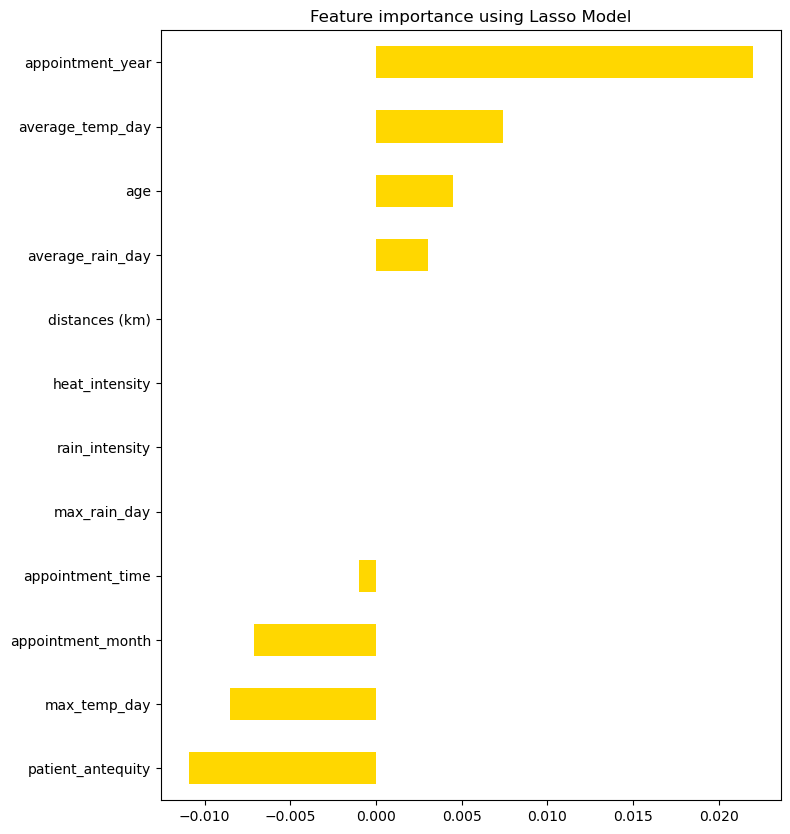

In [659]:
plot_importance(coef, 'Lasso')

In [707]:
from mlxtend.feature_selection import SequentialFeatureSelector

backward_feature_selector = SequentialFeatureSelector(RandomForestClassifier(n_jobs = -1), 
                                                      k_features = 7,
                                                      forward = False,
                                                      floating = False,
                                                      verbose = 2,
                                                      scoring = 'accuracy',
                                                      cv = 5).fit(X_train[numeric_features], y_train)

KeyboardInterrupt: 

In [846]:
X_train.columns

Index(['appointment_time', 'appointment_month', 'appointment_year', 'age',
       'under_12_years_old', 'over_60_years_old', 'patient_needs_companion',
       'average_temp_day', 'average_rain_day', 'max_temp_day', 'max_rain_day',
       'rain_intensity', 'heat_intensity', 'specialty_assist', 'specialty_enf',
       'specialty_occupational therapy', 'specialty_pedagogo',
       'specialty_physiotherapy', 'specialty_psychotherapy',
       'specialty_sem especialidade', 'specialty_speech therapy', 'gender_F',
       'gender_I', 'gender_M', 'disability_intellectual', 'disability_motor',
       'distances (km)', 'patient_antequity', 'appointment_day'],
      dtype='object')

In [855]:
# DE ML1
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 15, max_leaf_nodes = 75, min_samples_split = 35, max_features = 20, min_samples_leaf = 5), learning_rate = 0.1)
model.fit(X_train, y_train)
train_pred = model.predict(X_train)
predictions = model.predict(X_val)

metrics(y_train, train_pred, y_val, predictions)

# model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 15, max_leaf_nodes = 50, min_samples_split = 25, max_features = 15, min_samples_leaf = 8), learning_rate = 0.085)
# model.fit(X, y)
# print(accuracy_score(y, model.predict(X)))
# predictions = model.predict(test)
# target['Canceled'] = predictions
# target.to_csv('C:\\Users\\Afonso Cadete\\O meu disco\\Universidade\\2nd year\\1st semester\\Machine Learning\\Project\\Group10_Version74.csv')

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21920
           1       0.96      0.39      0.56      2047

    accuracy                           0.95     23967
   macro avg       0.95      0.69      0.76     23967
weighted avg       0.95      0.95      0.94     23967

0.9465097842867276
[[21884    36]
 [ 1246   801]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------

In [849]:
from sklearn.model_selection import GridSearchCV

# Parameter grid to search
param_grid = {
    'base_estimator__max_depth': [15, 20],
    'base_estimator__max_leaf_nodes': [50, 75, 100],
    'base_estimator__min_samples_split': [15, 25, 35],
    'base_estimator__max_features': [10, 15, 20],
    'base_estimator__min_samples_leaf': [5, 10, 15],
    'learning_rate': [0.085, 0.1]
}

# Create the AdaBoost model
base_model = DecisionTreeClassifier(max_depth=15, max_leaf_nodes=50, min_samples_split=25, max_features=15, min_samples_leaf=8)
adaboost_model = AdaBoostClassifier(base_model, learning_rate=0.085)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(adaboost_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get predictions using the best model
best_model = grid_search.best_estimator_
train_pred = best_model.predict(X_train)
predictions = best_model.predict(X_val)

# Display metrics using the best model
metrics(y_train, train_pred, y_val, predictions)


Best Parameters: {'base_estimator__max_depth': 15, 'base_estimator__max_features': 20, 'base_estimator__max_leaf_nodes': 75, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 35, 'learning_rate': 0.085}
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21920
           1       0.96      0.27      0.42      2047

    accuracy                           0.94     23967
   macro avg       0.95      0.64      0.70     23967
weighted avg       0.94      0.94      0.92     23967

0.9369132557266241
[[21897    23]
 [ 1489   558]]
______________________________________________________________________

Best Parameters: {'base_estimator__max_depth': 15, 'base_estimator__max_leaf_nodes': 75, 'learning_rate': 0.085}
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     21920
           1       0.96      0.23      0.37      2047

    accuracy                           0.93     23967
   macro avg       0.95      0.61      0.67     23967
weighted avg       0.94      0.93      0.91     23967

0.9331998164142362
[[21901    19]
 [ 1582   465]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9394
           1       0.78      0.09      0.15       878

    accuracy                           0.92     10272
   macro avg       0.85      0.54      0.56     10272
weighted avg       0.91      0.92      0.89     10272

0.9197819314641744
[[9373   21]
 [ 803   75]]

Best Parameters: {'base_estimator__max_depth': 15, 'base_estimator__max_features': 20, 'base_estimator__max_leaf_nodes': 75, 'base_estimator__min_samples_leaf': 5, 'base_estimator__min_samples_split': 35, 'learning_rate': 0.085}
___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     21920
           1       0.96      0.27      0.42      2047

    accuracy                           0.94     23967
   macro avg       0.95      0.64      0.70     23967
weighted avg       0.94      0.94      0.92     23967

0.9369132557266241
[[21897    23]
 [ 1489   558]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      9394
           1       0.77      0.10      0.17       878

    accuracy                           0.92     10272
   macro avg       0.85      0.55      0.56     10272
weighted avg       0.91      0.92      0.89     10272

0.920268691588785
[[9369   25]
 [ 794   84]]

In [830]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 15, max_leaf_nodes = 50, min_samples_split = 25, max_features = 15, min_samples_leaf = 8), learning_rate = 0.085)
model.fit(X_train_st, y_train)
train_pred = model.predict(X_train_st)
predictions = model.predict(X_val_st)

metrics(y_train, train_pred, y_val, predictions)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     21920
           1       0.99      0.07      0.13      2047

    accuracy                           0.92     23967
   macro avg       0.95      0.54      0.55     23967
weighted avg       0.93      0.92      0.89     23967

0.9206826052488839
[[21918     2]
 [ 1899   148]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------

In [831]:
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 15, max_leaf_nodes = 50, min_samples_split = 25, max_features = 15, min_samples_leaf = 8), learning_rate = 0.085)
model.fit(X_train_mm, y_train)
train_pred = model.predict(X_train_mm)
predictions = model.predict(X_val_mm)

metrics(y_train, train_pred, y_val, predictions)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
-----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     21920
           1       0.99      0.07      0.13      2047

    accuracy                           0.92     23967
   macro avg       0.95      0.53      0.54     23967
weighted avg       0.93      0.92      0.89     23967

0.9204322610255768
[[21918     2]
 [ 1905   142]]
___________________________________________________________________________________________________________
                                                VALIDATION                                                 
-----------------------------------------------------------------------------------